# Cifar10-CNN
This notebook shows how to perform handwritten digit classification using the CNN implemented with spooNN.

## 1. Preparation
First we import all the necessary components:

In [1]:
import sys
import math
import numpy as np
import os
import time
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime
from pynq import Xlnk
from pynq import Overlay
from pynq.mmio import MMIO
from loader import loader
import scipy.misc
from IPython.display import display

Next, we get the overlay that is in the same directory as this notebook. This is loaded onto the FPGA fabric on the PYNQ.
Then, a handle to the spooNN IP is obtained via nn_ctrl. Using this, we are able to write to the registers of the IP to configure it.

In [2]:
OVERLAY_PATH = 'overlay.bit'
overlay = Overlay(OVERLAY_PATH)
dma = overlay.axi_dma_0

xlnk = Xlnk()
nn_ctrl = MMIO(0x43c00000, length=1024)
print('Got nn_ctrl!')

Got nn_ctrl!


Here, we set some parameters. MINIBATCH_SIZE is how many images we want to classify in one go. The rest of the parameters are related to image properties (3 by 32 by 32 images, 8 bits per pixel, and 448 bits per line resulting in 54 total lines to transmit one image to the FPGA).

In [3]:
## Parameters
MINIBATCH_SIZE = 10
height = 32
width = 32
pixel_bits = 8*3
pixels_per_line = 448/pixel_bits
num_lines = int((height*width)/pixels_per_line)
print('num_lines per image: ' + str(num_lines))

num_lines per image: 54


Next, we can load the images we want to classify to the memory and display them.

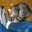

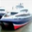

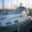

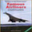

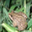

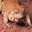

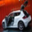

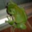

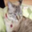

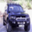

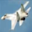

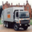

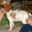

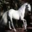

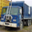

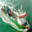

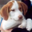

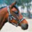

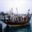

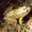

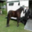

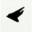

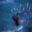

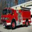

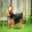

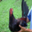

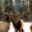

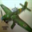

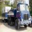

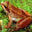

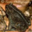

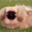

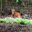

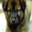

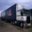

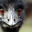

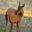

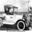

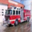

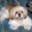

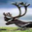

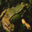

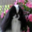

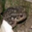

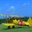

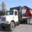

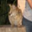

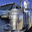

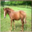

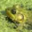

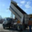

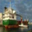

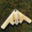

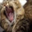

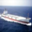

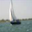

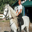

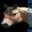

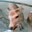

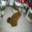

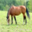

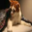

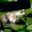

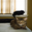

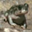

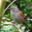

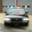

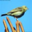

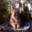

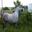

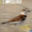

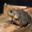

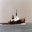

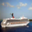

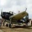

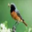

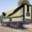

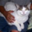

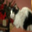

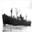

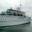

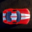

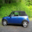

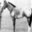

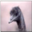

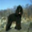

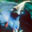

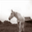

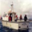

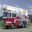

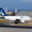

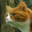

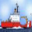

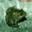

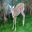

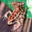

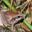

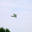

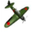

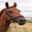

In [4]:
# Read images from file
from loader import loader
import numpy as np 
import scipy.misc
from IPython.display import display

l = loader()
l.load_cifar(path_to_file='test_batch', num_samples=MINIBATCH_SIZE, classes=10)
images = np.zeros((MINIBATCH_SIZE, height, width, 3))
for i, ret in enumerate(l.ret):
    images[i,:,:,:] = ret[0]
    
# Display images
for i in range(0,MINIBATCH_SIZE):
    display(scipy.misc.toimage( images[i,:,:,:] ))

## 2. Execution
Now we are ready to invoke the FPGA-based CNN to perform classification on the images that are in the memory.

- We first allocate the buffers that will be used by the DMA engine, to transfer images to the FPGA and get the results back.
- We write the images to the input buffer.
- We set a register (numReps) on the mnist-cnn IP, by writing MINIBATCH_SIZE to address 0x10. This is how many images the IP expects the DMA engine to send.
- We start the transfer on both receive and send channels.
- After the execution is complete, we display the classification results. Notice that they match the images we displayed earlier. 

In [6]:
in_buffer = xlnk.cma_array(shape=(MINIBATCH_SIZE*num_lines, 64), dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(MINIBATCH_SIZE, 16), dtype=np.int32)
print('allocated buffers')

for i in range(0,MINIBATCH_SIZE):
    in_buffer[i*num_lines:(i+1)*num_lines, 0:56] = np.reshape(images[i,:,:], (num_lines, 56))

start = time.time()
nn_ctrl.write(0x0, 0) # Reset
nn_ctrl.write(0x10, MINIBATCH_SIZE)
nn_ctrl.write(0x0, 1) # Deassert reset
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.transfer(in_buffer)
end = time.time()

time_per_image = (end-start)/MINIBATCH_SIZE
print("Time per image: " + str(time_per_image) + " s")
print("Images per second: " + str(1.0/time_per_image))

time.sleep(1)

for i in range(0,MINIBATCH_SIZE):
    print(str(np.argmax(out_buffer[i,:])))

allocated buffers
Time per image: 0.00024547576904296873 s
Images per second: 4073.721833721834
7
2
1
0
4
1
4
9
5
9


Since we worked only on 10 images in this notebook, the maximum image processing throughput capability of the CNN is not displayed. Try increasing the MINIBATCH_SIZE to observe a much higher throughput (You might want to comment out display part to skip displaying many images). 

## Reset the device

In [ ]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()